In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (40,3)
from sklearn.preprocessing import normalize
import scipy.io
import scipy.optimize as op

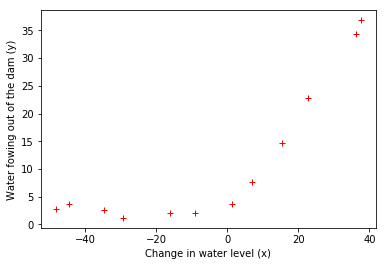

In [2]:
mat = scipy.io.loadmat('./ex5/ex5data1.mat')
X_orig = mat.get('X')
y = mat.get('y')

Xval_orig = mat.get('Xval')
yval = mat.get('yval')

Xtest_orig = mat.get('Xtest')
ytest = mat.get('ytest')

plt.plot(X_orig, y, 'r+')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()

X = np.column_stack([np.ones(len(X_orig)), X_orig])
Xval = np.column_stack([np.ones(len(Xval_orig)), Xval_orig])
Xtest = np.column_stack([np.ones(len(Xtest_orig)), Xtest_orig])

In [3]:
def compute_cost(theta, X, y, lambdaa):
    theta = theta.reshape((len(theta), 1))
    
    m = len(X)
    h = X.dot(theta)
    theta_reg = theta[1:]
    
    cost = 1 / 2 / m * (h - y).T.dot(h - y)
    reg  = lambdaa / 2 / m * theta_reg.T.dot(theta_reg)
    return np.sum(cost + reg)

# https://github.com/takehilo/coursera-machine-learning-python/blob/master/ex5/functions.py
def compute_grad(theta, X, y, lambdaa):
    theta = theta.reshape(len(theta), 1)
    
    m = len(X)
    h = X.dot(theta)

    error = h - y
    theta_reg = theta[1:]
    
    grad = np.zeros(theta.shape)
    grad[0] = 1 / m * X.T[0].dot(error)
    grad[1:] = 1 / m * X.T[1:].dot(error) + lambdaa / m * theta_reg

    return grad.ravel()

def train(X, y, lambdaa):
    return op.fmin_cg(f = compute_cost,
                      x0 = np.zeros(np.size(X, axis=1)),
                      args = (X, y, lambdaa),
                      fprime = compute_grad,
                      disp = False)

def train2(X, y, lambdaa, method='TNC'):
    result = op.minimize(fun = compute_cost,
                         x0 = np.zeros(np.size(X, axis=1)),
                         args = (X, y, lambdaa),
                         method = method,
                         jac = compute_grad)
    
    return result.x

def polyFeatures(X, p):
    col = X[:,0]
    columns = []
    for i in range(1, p + 1):
        columns.append(col ** i)

    return np.column_stack([*columns])

def normalizeFeatures(X):
    mean = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    return (X - mean) / sigma, mean, sigma
    
theta = np.array([1, 1])
cost = compute_cost(theta, X, y, 1);
print('Cost at theta = [1 ; 1]: {:.6f} (should be about 303.993192)'.format(cost));

grad = compute_grad(theta, X, y, 1);
print('Grad at theta = [1 ; 1]: {} (should be about [-15.303016; 598.250744])'.format(grad));

Cost at theta = [1 ; 1]: 303.993192 (should be about 303.993192)
Grad at theta = [1 ; 1]: [-15.30301567 598.25074417] (should be about [-15.303016; 598.250744])


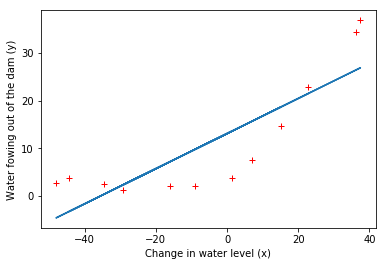

In [8]:
theta = train(X, y, 0)

plt.plot(X[:,1], y, 'r+')
plt.plot(X[:,1], X.dot(theta), '-')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()

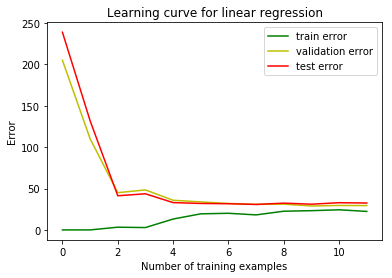

In [5]:
error_train = np.zeros(len(X))
error_val = np.zeros(len(X))
error_test = np.zeros(len(X))

for i in range(1, len(X) + 1):
    Xtrain = X[:i,:]
    ytrain = y[:i,:]
    
    theta = train(Xtrain, ytrain, 0)
    error_train[i - 1] = compute_cost(theta, Xtrain, ytrain, 0)
    error_val[i - 1] = compute_cost(theta, Xval, yval, 0)
    error_test[i - 1] = compute_cost(theta, Xtest, ytest, 0)
    
plt.plot(np.arange(0, len(X)), error_train, 'g-', label="train error")
plt.plot(np.arange(0, len(X)), error_val, 'y-', label="validation error")
plt.plot(np.arange(0, len(X)), error_test, 'r-', label="test error")
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.legend()
plt.show()

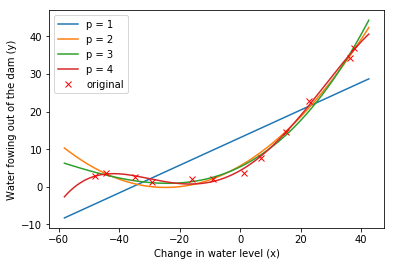

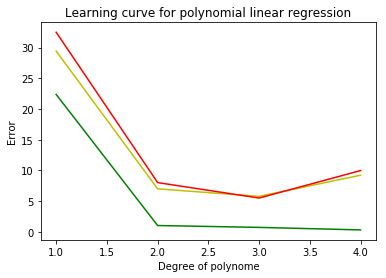

In [6]:
max_x = np.max(X)
min_x = np.min(X)
lambdaa = 0

error_train = np.zeros(4)
error_val = np.zeros(4)
error_test = np.zeros(4)

for p in range(1, 5):
    X_poly, mean, sigma = normalizeFeatures(polyFeatures(X_orig, p))
    Xval_poly = (polyFeatures(Xval_orig, p) - mean) / sigma
    Xtest_poly = (polyFeatures(Xtest_orig, p) - mean) / sigma

    X_poly = np.column_stack([np.ones(len(X_poly)), X_poly])
    Xval_poly = np.column_stack([np.ones(len(Xval_poly)), Xval_poly])
    Xtest_poly = np.column_stack([np.ones(len(Xtest_poly)), Xtest_poly])
    
    theta = train2(X_poly, y, lambdaa)
    
    x = np.arange(min_x - 10, max_x + 5, 0.05).reshape(-1, 1)
    x_poly = (polyFeatures(x, p) - mean) / sigma
    x_poly = np.column_stack([np.ones(len(x_poly)), x_poly])
    
    plt.plot(x, x_poly.dot(theta), '-', label='p = ' + str(p))
    
    error_train[p - 1] = compute_cost(theta, X_poly, ytrain, 0)
    error_val[p - 1] = compute_cost(theta, Xval_poly, yval, 0)
    error_test[p - 1] = compute_cost(theta, Xtest_poly, ytest, 0)
    
plt.plot(X_orig, y, 'rx', label='original')
plt.legend()
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()

plt.plot(
    np.arange(1, 5), error_train, 'g-', 
    np.arange(1, 5), error_val, 'y-',
    np.arange(1, 5), error_test, 'r-')
plt.xlabel('Degree of polynome')
plt.ylabel('Error')
plt.title('Learning curve for polynomial linear regression')
plt.show()

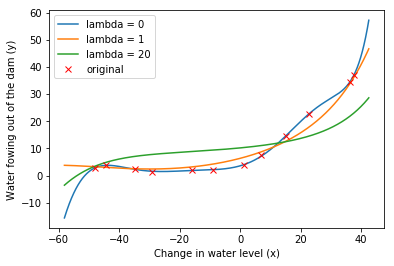

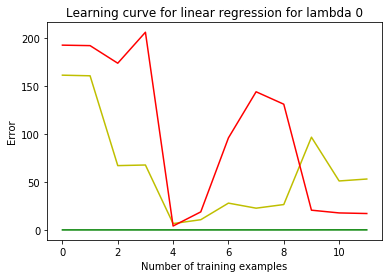

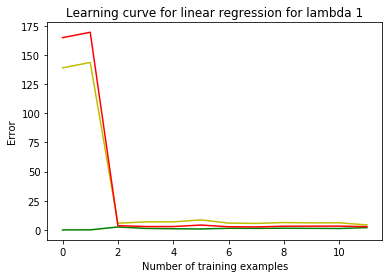

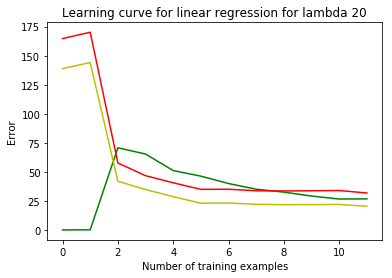

In [7]:
p = 8

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
X_poly, mean, sigma = normalizeFeatures(polyFeatures(X_orig, p))
Xval_poly = (polyFeatures(Xval_orig, p) - mean) / sigma
Xtest_poly = (polyFeatures(Xtest_orig, p) - mean) / sigma

X_poly = np.column_stack([np.ones(len(X_poly)), X_poly])
Xval_poly = np.column_stack([np.ones(len(Xval_poly)), Xval_poly])
Xtest_poly = np.column_stack([np.ones(len(Xtest_poly)), Xtest_poly])

# lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
lambdas = [0, 1, 20]

max_x = np.max(X)
min_x = np.min(X)

for i in range(len(lambdas)):
    lambdaa = lambdas[i]
    
    Xtrain = X_poly
    ytrain = y
    
    theta = train2(Xtrain, ytrain, lambdaa)

    x = np.arange(min_x - 10, max_x + 5, 0.05).reshape(-1, 1)
    x_poly = (polyFeatures(x, p) - mean) / sigma
    x_poly = np.column_stack([np.ones(len(x_poly)), x_poly])
    
    plt.plot(x, x_poly.dot(theta), '-', label='lambda = ' + str(lambdaa))

plt.plot(X_orig, y, 'rx', label='original')
plt.legend()
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()


for j, lambdaa in enumerate(lambdas):
    error_train = np.zeros(len(X))
    error_val = np.zeros(len(X))
    error_test = np.zeros(len(X))
    
    for i in range(1, len(X) + 1):
        Xtrain = X_poly[:i,:]
        ytrain = y[:i,:]

        theta = train(Xtrain, ytrain, lambdaa)
        error_train[i - 1] = compute_cost(theta, Xtrain, ytrain, 0)
        error_val[i - 1] = compute_cost(theta, Xval_poly, yval, 0)
        error_test[i - 1] = compute_cost(theta, Xtest_poly, ytest, 0)

    plt.plot(np.arange(0, len(X)), error_train, 'g-')
    plt.plot(np.arange(0, len(X)), error_val, 'y-')
    plt.plot(np.arange(0, len(X)), error_test, 'r-')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Learning curve for linear regression for lambda ' + str(lambdaa))
    plt.show()